In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0,'..')
from src.misc.separator import splitDataFrameList

In [45]:
def split_test_acc_list(df):
    return splitDataFrameList(df,'test_acc',',')

In [46]:
sns.set(style='whitegrid')

In [56]:
datasets = 'cora citeseer pubmed cora_full twitter webkb'.split()

In [57]:
# embedding results to be revised
df_emb = split_test_acc_list(pd.read_csv('reports/results/test_acc/test_acc_emb.csv'))
df_emb = df_emb[df_emb.method!='line1']

FileNotFoundError: File b'reports/results/test_acc/test_acc_emb.csv' does not exist

In [5]:
# feats baseline to be revised
df_baseline = pd.read_csv('../reports/results/test_acc/features-only-baseline.csv')
df_baseline['method'] = 'baseline'

In [6]:
df_baseline

,method,dataset,test_acc,test_avg,test_std
0,baseline,cora,"[0.5962529274004684, 0.5896955503512881, 0.608...",0.579129,0.022456
1,baseline,citeseer,"[0.5988950276243094, 0.630939226519337, 0.6348...",0.620215,0.019676
2,baseline,pubmed,"[0.7009250268308888, 0.6756273317319977, 0.711...",0.692462,0.022622
3,baseline,cora_full,"[0.4055233504852472, 0.39536246987559437, 0.39...",0.408393,0.007460
4,baseline,cornell,"[0.6213592233009708, 0.8058252427184466, 0.766...",0.712211,0.081279
5,baseline,texas,"[0.7372881355932204, 0.847457627118644, 0.7711...",0.763390,0.066940
6,baseline,washington,"[0.8802816901408451, 0.823943661971831, 0.7957...",0.803380,0.084258
7,baseline,wisconsin,"[0.6517412935323383, 0.736318407960199, 0.7263...",0.729154,0.084405
8,baseline,twitter,"[0.47099311701081614, 0.5776794493608652, 0.58...",0.574036,0.046703
9,baseline,webkb,"[0.6675531914893617, 0.6396276595744681, 0.638...",0.680332,0.047184


In [7]:
df_baseline = split_test_acc_list(df_baseline).drop(columns=['test_std','test_avg'])

In [231]:
def baseline(dataset,q=0.5):
    return df_baseline[df_baseline.dataset==dataset].test_acc.quantile(q=q)
def baseline_mean(dataset):
    return df_baseline[df_baseline.dataset==dataset].test_acc.mean()
def baseline_std(dataset):
    return df_baseline[df_baseline.dataset==dataset].test_acc.std()

In [180]:
def accuracy_boxplot(df, x_col='method',hue_col='dir',baselines=True,
                     titles=True, savefig_to=None,aspect = 1,
                     hue_order=None,legend = True, legend_out=False,
                     network_type = 'Original'):
    
#     df.loc[:,x_col] = df[x_col].map({'GATConv':'GAT', 'GCNConv':'GCN', 'SAGEConv':'GraphSAGE'})
#     if 'plot_row' in df.columns:
#         g = sns.FacetGrid(df, row='plot_row',col="dataset",sharey=True,height=4,aspect=aspect,palette=sns.color_palette('colorblind'),legend_out=legend_out)
#     else:
    g = sns.FacetGrid(df, col="dataset",sharey=True,height=3,aspect=aspect,palette=sns.color_palette('colorblind'),legend_out=legend_out)
    bp = g.map(sns.boxplot,"test_acc", x_col,hue_col,
               order=df[x_col].unique(),
               hue_order=(sorted(df[hue_col].unique()) if hue_order is None else hue_order),
               palette='colorblind',
               showfliers = False)
    if baselines:
        for ax,dataset in zip(g.axes[0],df.dataset.unique()):
            ax.axvline(baseline(dataset), ls='--',c='r')
        #     ax.axhline(baseline(dataset,q=.25), ls=':',c='r')
        #     ax.axhline(baseline(dataset,q=.75), ls=':',c='r')
    if legend:
        if legend_out:
            g.add_legend()
        else:
            g.axes[0][0].legend()
    if titles:
        bp.set_titles(network_type + ": {col_name}")
    else:
        bp.set_titles("")
    bp.set_xlabels("Accuracy")
    bp.set_ylabels("Method")
    plt.subplots_adjust(top=0.9)
#     g.fig.suptitle('Performance of unsupervised embedding methods on original network (red line is the baseline).')
    if savefig_to is None:
        return
    plt.savefig(savefig_to,bbox_inches='tight')


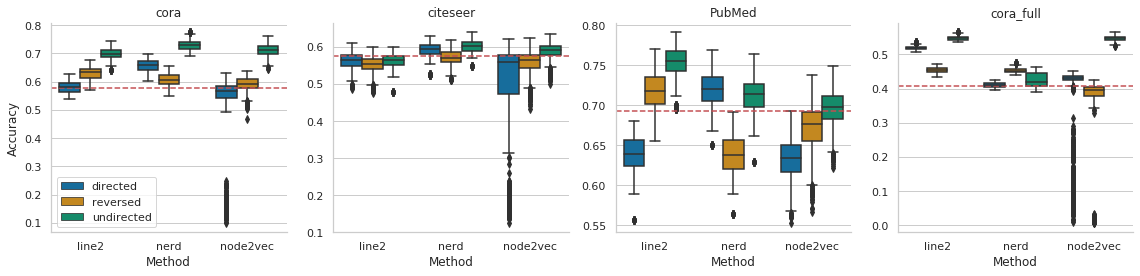

In [574]:
accuracy_boxplot(df_emb)

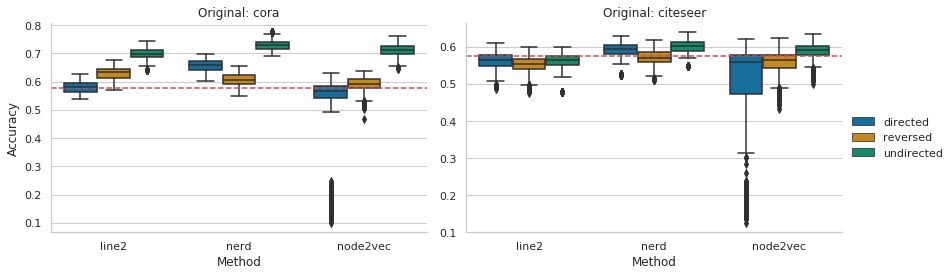

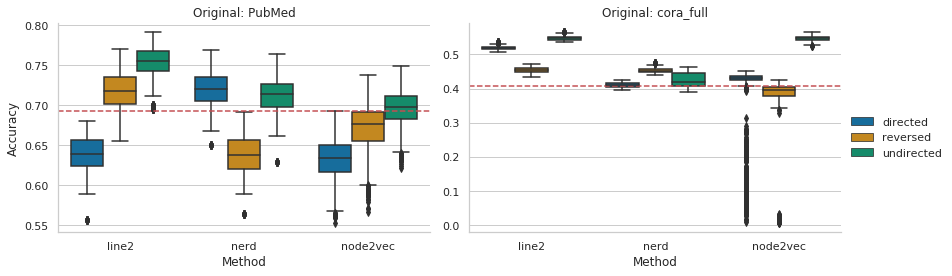

In [687]:
accuracy_boxplot(df_emb[df_emb.dataset.isin(['cora','citeseer'])],aspect = 1.5,savefig_to='charts/gnn-emb-1.pdf',legend_out=True)
accuracy_boxplot(df_emb[df_emb.dataset.isin(['PubMed','cora_full'])],aspect = 1.5,savefig_to='charts/gnn-emb-2.pdf',legend_out=True)

In [98]:
def load_model_results(models,datasets):
    dfs = []
    for model in models:
        for dataset in datasets:
            if not os.path.exists(f'../reports/results/test_acc/{model}_{dataset}.csv'):
                continue
            df = pd.read_csv(f'../reports/results/test_acc/{model}_{dataset}.csv')
            df['dataset'] = dataset
            dfs.append(df[(df.splits == 100) & (df.inits == 20)])
    return pd.concat(dfs,ignore_index=True,sort=False)

In [214]:

view_columns = 'dataset conv arch test_accs'.split()
df_results = load_model_results('gcn sage gat rgcn'.split(),datasets)
df_results = df_results[view_columns].rename(columns={'test_accs':'test_acc','arch':'directionality'})
df_results = split_test_acc_list(df_results)

In [215]:
df_results['flow'] = 'SYM'
df_results.loc[df_results.directionality == 'B','flow'] = 'ASYM'
df_results.loc[df_results.directionality == 'T','flow'] = 'ASYM+'

In [220]:
def collect_directionality_results(models,datasets):
    dir2name = {'undirected':'','directed':'_directed','reversed':'_reversed'}
    dfs = []
    for model in models:
        for dataset in datasets:
            for directionality in ['undirected','directed','reversed']:
                filename = f'../reports/results/test_acc/{model}_{dataset}{dir2name[directionality]}.csv'
                if not os.path.exists(filename):
                    continue
                cdf = pd.read_csv(filename)
                cdf['dataset'] = dataset
                cdf['directionality'] = directionality
                dfs.append(cdf[cdf.arch=='M'])
    return pd.concat(dfs,ignore_index=True,sort=False)

In [217]:
view_columns = 'dataset conv directionality test_accs'.split()
directionality_results = collect_directionality_results('gcn sage gat'.split(),datasets)
directionality_results = directionality_results[view_columns].rename(columns={'test_accs':'test_acc'})
directionality_results = split_test_acc_list(directionality_results)
directionality_results['flow'] = directionality_results['directionality']

/home/hhussain/anaconda3/envs/nips2/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [218]:
df_gnn_original = pd.concat([directionality_results[directionality_results.flow != 'undirected'],df_results],ignore_index=True)

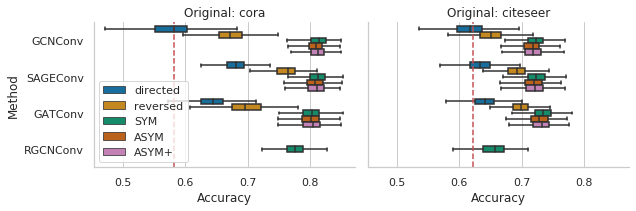

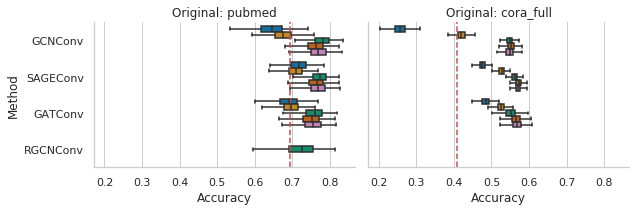

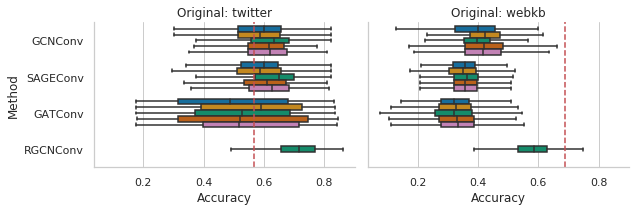

In [219]:
accuracy_boxplot(df_gnn_original[df_gnn_original.dataset.isin(datasets[:2])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-directionality-1-2.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'])
accuracy_boxplot(df_gnn_original[df_gnn_original.dataset.isin(datasets[2:4])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-directionality-3-4.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'],legend = False)
accuracy_boxplot(df_gnn_original[df_gnn_original.dataset.isin(datasets[4:])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-directionality-5-6.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'],legend = False)

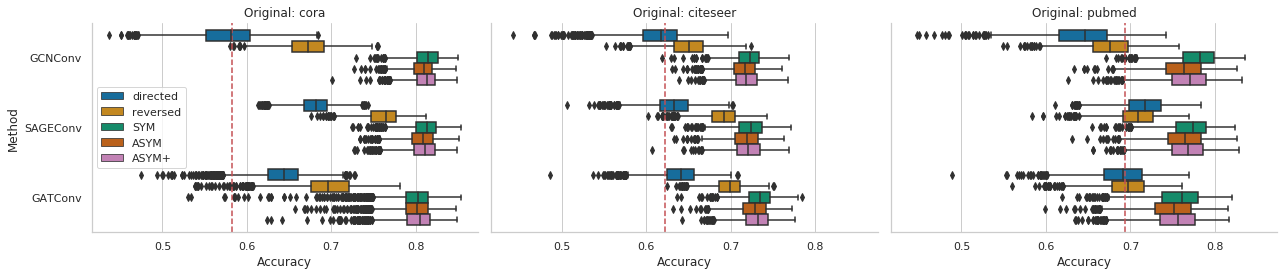

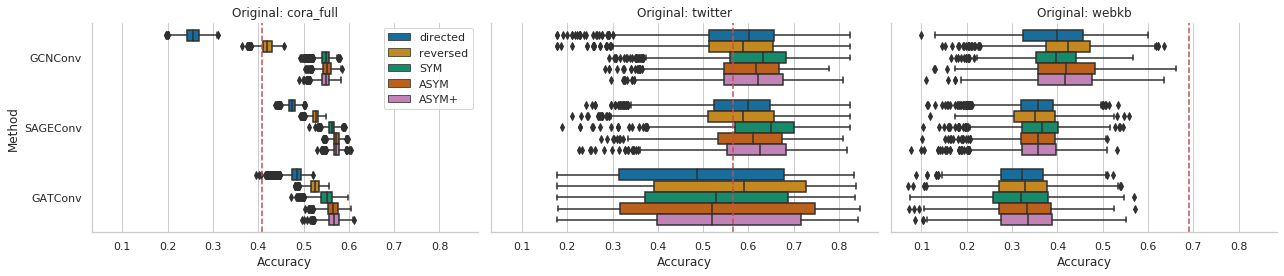

In [141]:
accuracy_boxplot(df_gnn_original[df_gnn_original.dataset.isin(datasets[:3])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-directionality-1-3.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'])
accuracy_boxplot(df_gnn_original[df_gnn_original.dataset.isin(datasets[3:])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-directionality-4-6.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'])

In [161]:
def load_confs():
    view_columns = 'dataset conv arch directionality test_accs confmodel_num'.split()
    def load_one_conf(dataset,model,directionality):
        filename = f'../reports/results/test_acc/{model}_{dataset}_conf{("_"+directionality) if directionality != "undirected" else ""}.csv'
        if not os.path.exists(filename):
            return pd.DataFrame(columns=view_columns)
        df = pd.read_csv(filename)
        df['dataset'] = dataset
        df['directionality'] = directionality
        df = df[~np.isnan(df.confmodel_num)]
        df = df[view_columns]
        return df
    dfs = []
    for dataset in datasets:
        for model in 'gcn sage gat'.split():
            for directionality in 'undirected directed reversed'.split():
                dfs.append(load_one_conf(dataset,model,directionality))
    df_conf =pd.concat(dfs)
    df_conf['flow'] = 'SYM'
    df_conf.loc[df_conf.arch == 'B','flow'] = 'ASYM'
    df_conf.loc[df_conf.arch == 'T','flow'] = 'ASYM+'
    df_conf.loc[df_conf.directionality == 'directed','flow'] = 'directed'
    df_conf.loc[df_conf.directionality == 'reversed','flow'] = 'reversed'
    df_conf = df_conf.rename(columns = {'test_accs':'test_acc'})
    return df_conf

In [158]:
def load_sbms():
    view_columns = 'dataset conv arch directionality test_accs sbm_num'.split()
    def load_one_sbm(dataset,model,directionality):
        filename = f'../reports/results/test_acc/{model}_{dataset}_sbm{("_"+directionality) if directionality != "undirected" else ""}.csv'
        if not os.path.exists(filename):
            return pd.DataFrame(columns=view_columns)
        df = pd.read_csv(filename)
        df['dataset'] = dataset
        df['directionality'] = directionality
        df = df[~np.isnan(df.sbm_num)]
        df = df[view_columns]
        return df
    dfs = []
    for dataset in datasets:
        for model in 'gcn sage gat'.split():
            for directionality in 'undirected directed reversed'.split():
                dfs.append(load_one_sbm(dataset,model,directionality))
    df_sbm =pd.concat(dfs)
    df_sbm['flow'] = 'SYM'
    df_sbm.loc[df_sbm.arch == 'B','flow'] = 'ASYM'
    df_sbm.loc[df_sbm.arch == 'T','flow'] = 'ASYM+'
    df_sbm.loc[df_sbm.directionality == 'directed','flow'] = 'directed'
    df_sbm.loc[df_sbm.directionality == 'reversed','flow'] = 'reversed'
    df_sbm = df_sbm.rename(columns = {'test_accs':'test_acc'})
    return df_sbm

In [163]:
df_sbm=load_sbms()
df_sbm = split_test_acc_list(df_sbm)

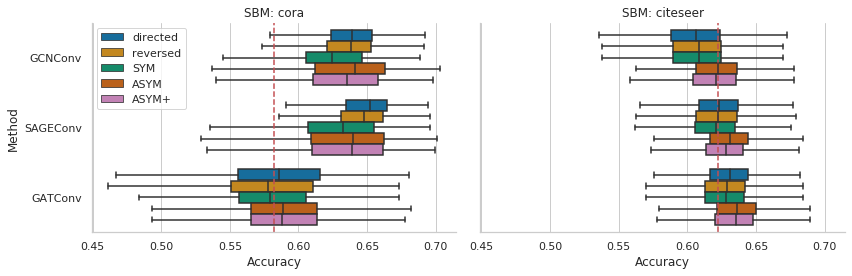

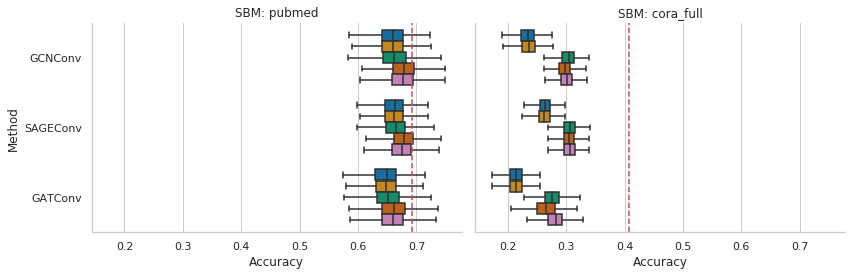

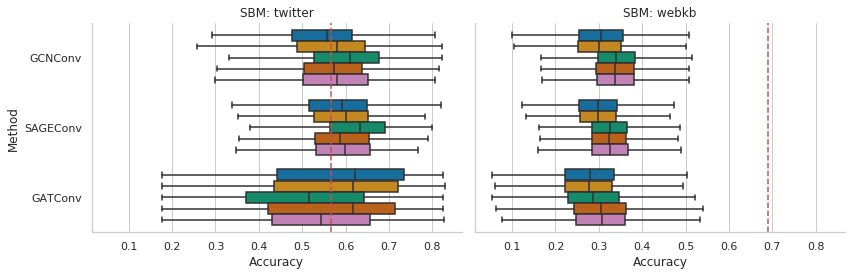

In [178]:
accuracy_boxplot(df_sbm[df_sbm.dataset.isin(datasets[:2])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-sbm-1-2.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'],network_type='SBM')
accuracy_boxplot(df_sbm[df_sbm.dataset.isin(datasets[2:4])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-sbm-3-4.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'],legend = False,network_type='SBM')
accuracy_boxplot(df_sbm[df_sbm.dataset.isin(datasets[4:])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-sbm-5-6.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'],legend = False,network_type='SBM')

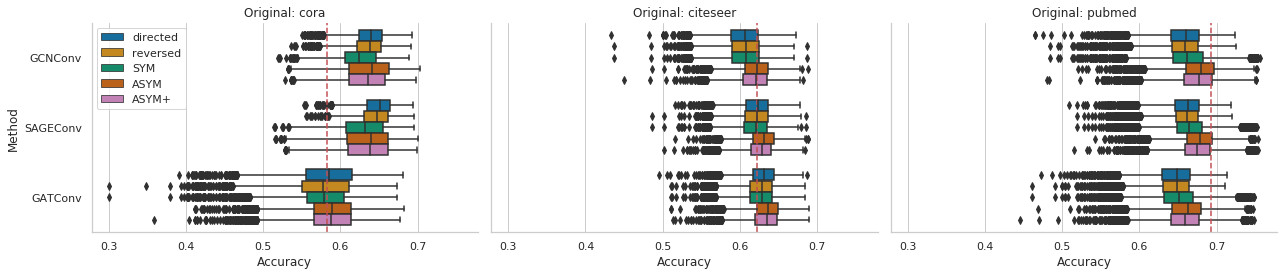

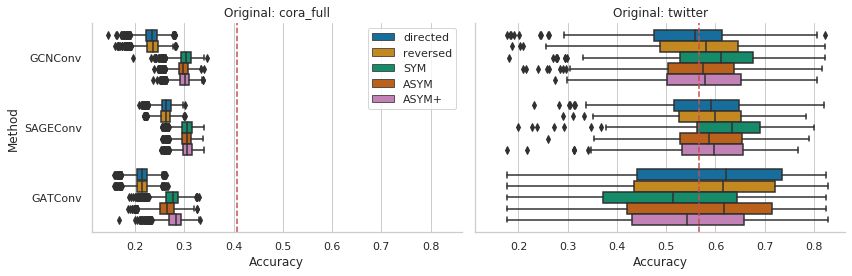

In [151]:
accuracy_boxplot(df_sbm[df_sbm.dataset.isin(datasets[:3])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-sbm-1-3.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'])
accuracy_boxplot(df_sbm[df_sbm.dataset.isin(datasets[3:])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-sbm-4-6.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'])

In [165]:
df_conf=load_confs()
df_conf = split_test_acc_list(df_conf)

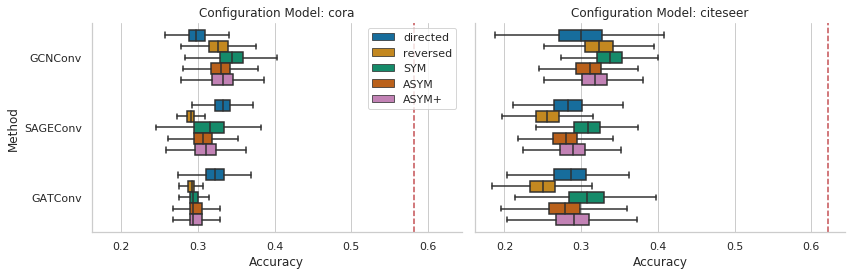

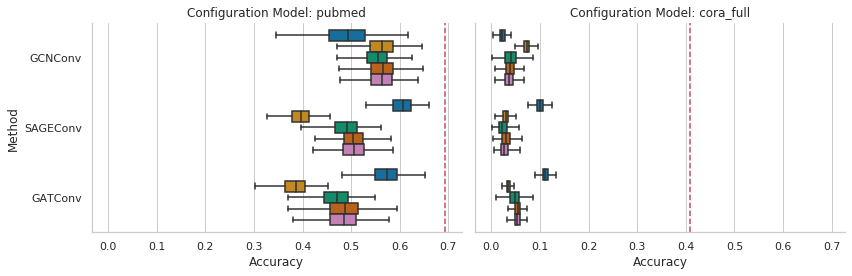

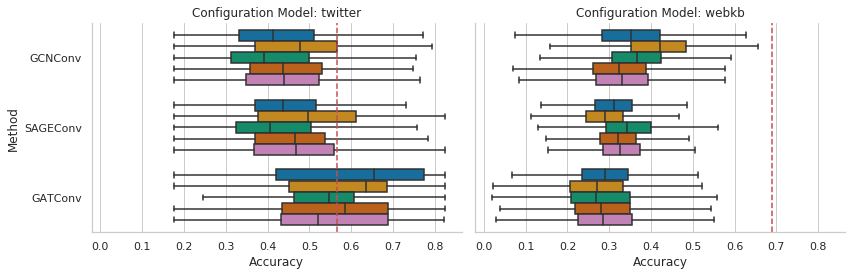

In [179]:
accuracy_boxplot(df_conf[df_conf.dataset.isin(datasets[:2])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-conf-1-2.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'],network_type='Configuration Model')
accuracy_boxplot(df_conf[df_conf.dataset.isin(datasets[2:4])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-conf-3-4.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'],legend = False,network_type='Configuration Model')
accuracy_boxplot(df_conf[df_conf.dataset.isin(datasets[4:])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-conf-5-6.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'],legend = False,network_type='Configuration Model')

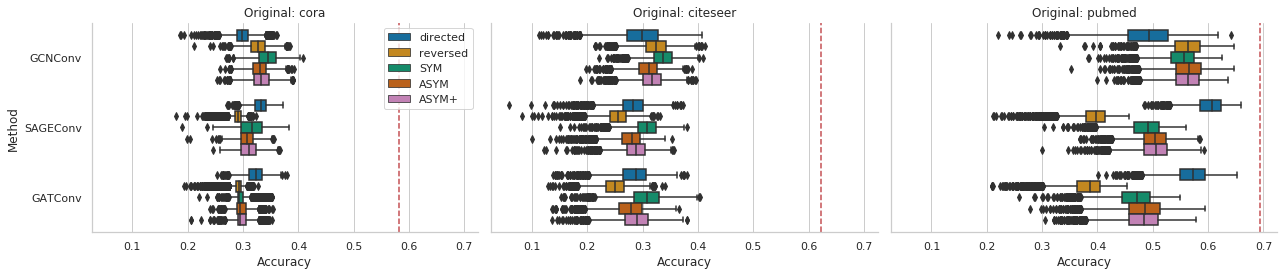

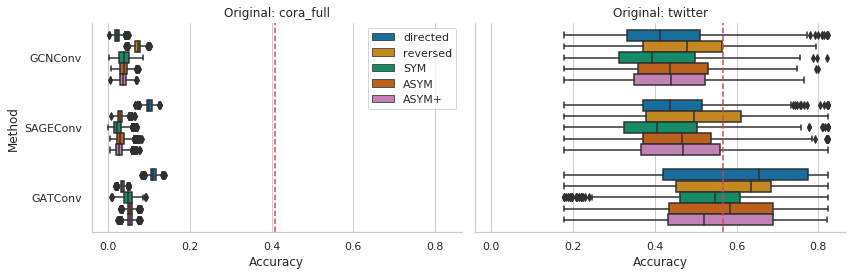

In [154]:
accuracy_boxplot(df_conf[df_conf.dataset.isin(datasets[:3])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-conf-1-3.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'])
accuracy_boxplot(df_conf[df_conf.dataset.isin(datasets[3:])], x_col='conv',hue_col='flow',aspect = 1.5,savefig_to='../reports/figures/evaluation/gnn-conf-4-6.pdf',hue_order=['directed','reversed','SYM','ASYM','ASYM+'])

In [186]:
def presentable_cell(df):
    #TODO: generate cell for each conv/method
#     columns = [df[df.conv==x].test_acc for x in df.conv.unique()]
#     return pd.DataFrame({i:[f'{x.mean()*100:.2f}(+-{x.std()*100:.2f})'] for i,x in zip(df.conv.unique(),columns)})
    m = df.test_acc.mean()
    s = df.test_acc.std()
#     return f'{m*100:2.2f}'
    return f'{m*100:2.2f} ({s*100:.1f})'

In [650]:
def to_latex_table2(df):
    df = pd.DataFrame(df.groupby(['dataset','flow','conv','Network'], sort=False).apply(presentable_cell)).reset_index()
    df = df.rename(columns={'dataset':'Dataset','flow':'Flow','conv':'GNN'})
    df = pd.pivot_table(df,values=0,index = ['GNN','Network'],columns=['Dataset','Flow'],aggfunc=np.sum)
    
    return df.to_latex(na_rep='---')#.replace('directed','')

In [223]:
def to_latex_table3(df):
    dataset_map = {'cora':'0CORA-ML','citeseer':'1CiteSeer','pubmed':'2PubMed',
                   'cora_full':'3Cora-Full', 'twitter':'4Twitter','webkb':'5WebKB'}
    conv_map = {'GCNConv':'0GCN','SAGEConv':'1SAGE','GATConv':'2GAT','RGCNConv':'3RGCN'}
    flow_map = {'directed':'0directed','reversed':'1reversed','SYM':'2SYM','ASYM':'3ASYM','ASYM+':'4ASYM+'}
    df = df.copy()
    
    
    df['dataset'] = df['dataset'].map(dataset_map)
    df['conv'] = df['conv'].map(conv_map)
    df['flow'] = df['flow'].map(flow_map)
    df['Network'] = df['Network'].map({'original':'0Original network','conf':'1Configuration model', 'sbm':'2SBM'})
    df = pd.DataFrame(df.groupby(['dataset','flow','conv','Network'], sort=False).apply(presentable_cell)).reset_index()
    df = df.rename(columns={'dataset':'Dataset','flow':'Flow','conv':'GNN'})
    df = pd.pivot_table(df,values=0,index = ['GNN','Flow'],columns=['Network','Dataset'],aggfunc=np.sum)
    df = df.rename(columns=lambda x:x[1:],index=lambda x:x[1:])
#     return df
    return df.to_latex(na_rep='---').replace('directed','$\\rightarrow$').replace(
        'reversed','$\\leftarrow$').replace('reversed','$\\leftrightarrow$').replace(' (','\\tiny{$\\pm$').replace(')','}')
        

In [196]:
cur_ds  = 'cora_full twitter webkb'.split()
df1 = df_gnn_original.loc[df_gnn_original.dataset.isin(cur_ds),['conv','dataset','flow','test_acc']]
df1['Network'] = 'original'
df2 = df_conf.loc[df_conf.dataset.isin(cur_ds),['conv','dataset','flow','test_acc']]
df2['Network'] = 'conf'
df3 = df_sbm.loc[df_sbm.dataset.isin(cur_ds),['conv','dataset','flow','test_acc']]
df3['Network'] = 'sbm'
df_show = pd.concat([df1,df2,df3],ignore_index=True,sort=False)

In [193]:
cur_ds  = 'cora citeseer pubmed'.split()
df1 = df_gnn_original.loc[df_gnn_original.dataset.isin(cur_ds),['conv','dataset','flow','test_acc']]
df1['Network'] = 'original'
df2 = df_conf.loc[df_conf.dataset.isin(cur_ds),['conv','dataset','flow','test_acc']]
df2['Network'] = 'conf'
df3 = df_sbm.loc[df_sbm.dataset.isin(cur_ds),['conv','dataset','flow','test_acc']]
df3['Network'] = 'sbm'
df_show = pd.concat([df1,df2,df3],ignore_index=True,sort=False)

In [224]:
cur_ds  = 'cora citeseer pubmed cora_full twitter webkb'.split()
df1 = df_gnn_original.loc[df_gnn_original.dataset.isin(cur_ds),['conv','dataset','flow','test_acc']]
df1['Network'] = 'original'
df2 = df_conf.loc[df_conf.dataset.isin(cur_ds),['conv','dataset','flow','test_acc']]
df2['Network'] = 'conf'
df3 = df_sbm.loc[df_sbm.dataset.isin(cur_ds),['conv','dataset','flow','test_acc']]
df3['Network'] = 'sbm'


In [239]:
print('& & '+' & '.join([f'{baseline_mean(d)*100:.2f}'+'\\tiny$\pm$'+f'{baseline_std(d)*100:.1f}' for d in cur_ds]) + '\\\\')

& & 57.91\tiny$\pm$2.3 & 62.02\tiny$\pm$2.0 & 69.25\tiny$\pm$2.3 & 40.84\tiny$\pm$0.7 & 57.40\tiny$\pm$4.7 & 68.03\tiny$\pm$4.7\\


In [225]:
print(to_latex_table3(df1))

\begin{tabular}{llllllll}
\toprule
     & Network & \multicolumn{6}{l}{Original network} \\
     & Dataset &          CORA-ML &     CiteSeer &       PubMed &    Cora-Full &       Twitter &        WebKB \\
GNN & Flow &                  &              &              &              &               &              \\
\midrule
GCN & $\rightarrow$ &      57.71\tiny{$\pm$3.8} &  61.33\tiny{$\pm$3.4} &  64.11\tiny{$\pm$4.3} &  25.60\tiny{$\pm$1.9} &  57.83\tiny{$\pm$10.3} &  38.92\tiny{$\pm$8.9} \\
     & $\leftarrow$ &      67.27\tiny{$\pm$2.9} &  64.96\tiny{$\pm$2.6} &  67.50\tiny{$\pm$3.1} &  41.97\tiny{$\pm$1.3} &  57.79\tiny{$\pm$10.3} &  42.13\tiny{$\pm$7.4} \\
     & SYM &      81.24\tiny{$\pm$1.7} &  72.13\tiny{$\pm$1.9} &  77.84\tiny{$\pm$2.7} &  54.78\tiny{$\pm$1.2} &   61.89\tiny{$\pm$8.9} &  39.45\tiny{$\pm$6.5} \\
     & ASYM &      80.78\tiny{$\pm$1.6} &  71.52\tiny{$\pm$1.9} &  76.06\tiny{$\pm$3.0} &  55.16\tiny{$\pm$1.2} &   60.49\tiny{$\pm$8.5} &  41.78\tiny{$\pm$8.8} \\
     &

In [200]:
print(to_latex_table3(df2))

\begin{tabular}{llllllll}
\toprule
    & Network & \multicolumn{6}{l}{Configuration model} \\
    & Dataset &             CORA-ML &     CiteSeer &       PubMed &    Cora-Full &       Twitter &        WebKB \\
GNN & Flow &                     &              &              &              &               &              \\
\midrule
GCN & $\rightarrow$ &         29.92\tiny{$\pm$1.8} &  29.71\tiny{$\pm$4.1} &  48.92\tiny{$\pm$5.4} &   2.30\tiny{$\pm$0.7} &  41.83\tiny{$\pm$14.6} &  35.20\tiny{$\pm$9.4} \\
    & $\leftarrow$ &         32.64\tiny{$\pm$1.8} &  32.27\tiny{$\pm$2.7} &  56.02\tiny{$\pm$3.4} &   7.28\tiny{$\pm$0.8} &  46.88\tiny{$\pm$13.1} &  41.47\tiny{$\pm$9.3} \\
    & SYM &         34.26\tiny{$\pm$2.2} &  33.66\tiny{$\pm$2.4} &  55.21\tiny{$\pm$3.1} &   3.94\tiny{$\pm$1.5} &  40.89\tiny{$\pm$13.2} &  36.62\tiny{$\pm$8.0} \\
    & ASYM &         32.93\tiny{$\pm$1.9} &  30.93\tiny{$\pm$2.5} &  56.19\tiny{$\pm$3.4} &   3.83\tiny{$\pm$1.1} &  44.08\tiny{$\pm$12.9} &  32.39\tiny{$\p

In [201]:
print(to_latex_table3(df3))

\begin{tabular}{llllllll}
\toprule
    & Network & \multicolumn{6}{l}{SBM} \\
    & Dataset &      CORA-ML &     CiteSeer &       PubMed &    Cora-Full &       Twitter &        WebKB \\
GNN & Flow &              &              &              &              &               &              \\
\midrule
GCN & $\rightarrow$ &  63.78\tiny{$\pm$2.2} &  60.46\tiny{$\pm$2.6} &  65.63\tiny{$\pm$3.0} &  23.32\tiny{$\pm$1.6} &  54.26\tiny{$\pm$10.9} &  30.59\tiny{$\pm$7.6} \\
    & $\leftarrow$ &  63.63\tiny{$\pm$2.2} &  60.56\tiny{$\pm$2.6} &  65.59\tiny{$\pm$3.1} &  23.45\tiny{$\pm$1.6} &  56.01\tiny{$\pm$11.0} &  30.19\tiny{$\pm$7.4} \\
    & SYM &  62.44\tiny{$\pm$2.8} &  60.54\tiny{$\pm$2.6} &  66.11\tiny{$\pm$3.5} &  30.24\tiny{$\pm$1.6} &  59.39\tiny{$\pm$10.8} &  34.03\tiny{$\pm$6.5} \\
    & ASYM &  63.63\tiny{$\pm$3.3} &  62.01\tiny{$\pm$2.4} &  67.64\tiny{$\pm$3.0} &  29.70\tiny{$\pm$1.4} &   56.46\tiny{$\pm$9.9} &  33.72\tiny{$\pm$6.5} \\
    & ASYM+ &  63.26\tiny{$\pm$3.1} &  61.84\tin

In [197]:
print(to_latex_table3(df_show))

\begin{tabular}{lllllllllll}
\toprule
    & Network & \multicolumn{3}{l}{Original network} & \multicolumn{3}{l}{Configuration model} & \multicolumn{3}{l}{SBM} \\
    & Dataset &        Cora-Full &       Twitter &        WebKB &           Cora-Full &       Twitter &        WebKB &    Cora-Full &       Twitter &        WebKB \\
GNN & Flow &                  &               &              &                     &               &              &              &               &              \\
\midrule
GCN & $\rightarrow$ &      25.60\tiny{$\pm$1.9} &  57.83\tiny{$\pm$10.3} &  38.92\tiny{$\pm$8.9} &          2.30\tiny{$\pm$0.7} &  41.83\tiny{$\pm$14.6} &  35.20\tiny{$\pm$9.4} &  23.32\tiny{$\pm$1.6} &  54.26\tiny{$\pm$10.9} &  30.59\tiny{$\pm$7.6} \\
    & $\leftarrow$ &      41.97\tiny{$\pm$1.3} &  57.79\tiny{$\pm$10.3} &  42.13\tiny{$\pm$7.4} &          7.28\tiny{$\pm$0.8} &  46.88\tiny{$\pm$13.1} &  41.47\tiny{$\pm$9.3} &  23.45\tiny{$\pm$1.6} &  56.01\tiny{$\pm$11.0} &  30.19\tiny{$\pm$7.4

In [646]:
print(to_latex_table2(df_show))

\begin{tabular}{llllllll}
\toprule
         & Dataset & \multicolumn{2}{l}{PubMed} & \multicolumn{2}{l}{citeseer} & \multicolumn{2}{l}{cora-full} \\
         & Network &          conf &      original &          conf &      original &          conf &      original \\
GNN & Flow &               &               &               &               &               &               \\
\midrule
GATConv & ASYM &  48.47 (4.58) &  75.09 (3.02) &  28.01 (2.42) &  67.65 (1.75) &   5.43 (0.72) &  56.44 (1.57) \\
         & ASYM+ &  48.28 (4.86) &  75.57 (2.99) &  28.90 (2.41) &  68.08 (1.59) &   5.29 (0.79) &  56.63 (1.61) \\
         & SYM &  45.21 (5.09) &  75.65 (3.20) &  30.13 (2.59) &  68.37 (1.62) &   4.84 (1.39) &  54.99 (1.85) \\
         & directed &  37.63 (4.20) &  69.83 (2.71) &  25.04 (2.06) &  62.95 (1.94) &  11.11 (0.77) &  48.15 (1.82) \\
         & reversed &  59.06 (3.41) &  70.04 (2.88) &  28.07 (2.51) &  59.21 (2.09) &   3.50 (0.47) &  52.49 (1.28) \\
GCNConv & ASYM &  45.37 (4.82) &

In [443]:
def to_latex_table(df):
    df = pd.DataFrame(df.groupby(['dataset','flow','conv'], sort=False).apply(presentable_cell)).reset_index()
    df = df.rename(columns={'dataset':'Dataset','flow':'Flow','conv':'Model'})
    df = df.applymap(lambda x : x.replace('_','-'))
    df = pd.pivot_table(df,values=0,index = ['Dataset','Flow'],columns=['Model'],aggfunc=np.sum)
    
    return df.to_latex(na_rep='---')

In [444]:
print(to_latex_table(df_conf))

\begin{tabular}{lllll}
\toprule
          & Model &       GATConv &       GCNConv &      SAGEConv \\
Dataset & Flow &               &               &               \\
\midrule
PubMed & ASYM &  48.47 (4.58) &  45.37 (4.82) &  44.28 (6.11) \\
          & ASYM+ &  48.28 (4.86) &  44.71 (4.51) &  43.44 (6.13) \\
          & SYM &  45.21 (5.09) &  42.91 (4.49) &  40.40 (6.97) \\
          & directed &  37.63 (4.20) &  55.00 (3.33) &  36.88 (5.05) \\
          & reversed &  59.06 (3.41) &  37.31 (5.81) &  60.91 (3.15) \\
citeseer & ASYM &  28.01 (2.42) &  31.32 (2.14) &  28.93 (1.98) \\
          & ASYM+ &  28.90 (2.41) &  31.90 (2.19) &  29.68 (2.00) \\
          & SYM &  30.13 (2.59) &  33.64 (2.09) &  30.89 (2.03) \\
          & directed &  25.04 (2.06) &  31.64 (2.67) &  25.85 (1.92) \\
          & reversed &  28.07 (2.51) &  30.97 (3.35) &  29.04 (2.18) \\
cora & ASYM &  22.14 (5.00) &  27.66 (2.57) &  25.15 (2.36) \\
          & ASYM+ &  21.50 (5.22) &  28.35 (2.54) &  26.13 (2.44) \\


In [377]:
df_gnn_original.columns

Index(['conv', 'dataset', 'directionality', 'test_acc', 'flow'], dtype='object')

In [378]:
df_emb.columns

Index(['dataset', 'dir', 'method', 'test_acc', 'test_avg', 'test_std'], dtype='object')

In [386]:
mix_cols = ['conv', 'dataset', 'flow', 'test_acc']
df_mixed = pd.concat([df_emb.rename(columns={'dir':'flow', 'method':'conv'}),df_gnn_original],ignore_index=True,sort=False).drop(columns=['directionality'])
df_mixed.loc[df_mixed.flow == 'undirected','flow']= 'SYM'

In [420]:
print(to_latex_table(df_mixed))

\begin{tabular}{llllllll}
\toprule
          & Model &       GATConv &       GCNConv &      SAGEConv &         line2 &          nerd &       node2vec \\
Dataset & Flow &               &               &               &               &               &                \\
\midrule
PubMed & ASYM &  75.09 (3.02) &  76.16 (3.03) &  76.22 (2.70) &           --- &           --- &            --- \\
          & ASYM+ &  75.57 (2.99) &  76.77 (2.93) &  76.65 (2.65) &           --- &           --- &            --- \\
          & SYM &  75.65 (3.20) &  77.84 (2.69) &  77.07 (2.65) &  75.39 (2.03) &  71.09 (2.23) &   69.59 (2.24) \\
          & directed &  69.83 (2.71) &  67.50 (3.07) &  70.79 (2.58) &  63.80 (2.30) &  72.00 (2.14) &   63.31 (2.43) \\
          & reversed &  70.04 (2.88) &  64.11 (4.28) &  71.55 (2.78) &  71.71 (2.18) &  63.75 (2.51) &   67.26 (2.77) \\
citeseer & ASYM &  67.65 (1.75) &  67.59 (1.65) &  67.88 (1.64) &           --- &           --- &            --- \\
          & ASYM+

In [448]:
df = pd.DataFrame(df_baseline.groupby(['dataset'], sort=False).apply(presentable_cell)).reset_index()
df = df.rename(columns={'dataset':'Dataset'})
df = df.applymap(lambda x : x.replace('_','-'))
df = pd.pivot_table(df,values=0,index = [],columns=['Dataset'],aggfunc=np.sum)
print(df.to_latex())

\begin{tabular}{lllll}
\toprule
Dataset &        PubMed &      citeseer &          cora &     cora-full \\
\midrule
0 &  69.02 (2.29) &  57.26 (1.88) &  57.58 (2.27) &  40.84 (0.75) \\
\bottomrule
\end{tabular}

